In [55]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [56]:
def rmse(y,tx,weight):
    e = y[:,np.newaxis] - tx @ weight[:,np.newaxis]
    loss = sum(abs(e)) / tx.shape[0]
    rmse = np.sqrt(2 * loss)
    return rmse.item()

def least_squares(y, tx):
    """calculate the least squares solution."""
    gram = np.linalg.inv(tx.transpose() @ tx)
    weight = gram @ tx.transpose() @ y
    return weight, rmse(y,tx,weight)

### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [57]:
from helpers import *
from plots import *
def test_your_least_squares():
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    w,e = least_squares(y,tx)
    print("Weights : " + str(w))
    print("Loss : " + str(e))

Test it here

In [58]:
test_your_least_squares()

Weights : [73.293922   13.47971243]
Loss : 2.9748984248645556


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [59]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [60]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    return (x[:,np.newaxis] @ np.ones([1,degree+1])) ** np.array(range(degree + 1))
    

Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [61]:
from plots import *

def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        tx = build_poly(x,degree)
        weights,rmse = least_squares(y,tx)

        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()
    plt.savefig("visualize_polynomial_regression")
    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.8615833306569375
Processing 2th experiment, degree=3, rmse=0.6545977638761765
Processing 3th experiment, degree=7, rmse=0.632849848594655
Processing 4th experiment, degree=12, rmse=1.1748559485218435


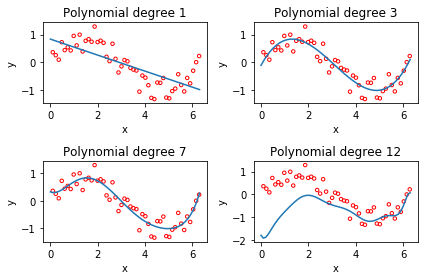

In [62]:
polynomial_regression()

# 2 Evaluating model predication performance


Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [90]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    x = np.random.permutation(x)
    nb = int(x.shape[0] * ratio)
    train_x = x[:nb]
    train_y = y[:nb]
    test_x = x[nb:]
    test_y = y[nb:]
    return train_x, train_y, test_x, test_y

Then, test your `split_data` function below.

In [91]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees."""
    train_x, train_y, test_x, test_y = split_data(x,y,ratio,seed)

    train_x = build_poly(train_x,degree)
    test_x = build_poly(test_x,degree)
    
    weights,rmse_tr = least_squares(train_y, train_x)
    
    rmse_te = rmse(test_y,test_x, weights)
    
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))


In [92]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.5, 0.1]

for split_ratio in split_ratios:
    for degree in degrees:
        train_test_split_demo(x, y, degree, split_ratio, seed)

proportion=0.9, degree=1, Training RMSE=1.109, Testing RMSE=1.046
proportion=0.9, degree=3, Training RMSE=1.110, Testing RMSE=1.059
proportion=0.9, degree=7, Training RMSE=1.093, Testing RMSE=1.114
proportion=0.9, degree=12, Training RMSE=1.017, Testing RMSE=1.306
proportion=0.5, degree=1, Training RMSE=1.011, Testing RMSE=1.196
proportion=0.5, degree=3, Training RMSE=1.009, Testing RMSE=1.203
proportion=0.5, degree=7, Training RMSE=0.954, Testing RMSE=1.253
proportion=0.5, degree=12, Training RMSE=0.890, Testing RMSE=1.427
proportion=0.1, degree=1, Training RMSE=1.121, Testing RMSE=1.130
proportion=0.1, degree=3, Training RMSE=0.683, Testing RMSE=1.633
proportion=0.1, degree=7, Training RMSE=1.251, Testing RMSE=3.693
proportion=0.1, degree=12, Training RMSE=4.469, Testing RMSE=5.330


# 3 Ridge Regression
Please fill in the function below.

In [93]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression."""
    gram = np.linalg.inv(tx.transpose() @ tx + (lambda_ / (2* tx.shape[0]) * np.identity(tx.shape[1])))
    weight = gram @ tx.transpose() @ y
    return weight, rmse(y,tx,weight)

In [94]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)
    train_x, train_y, test_x, test_y = split_data(x,y,ratio,seed)

    train_x = build_poly(train_x,degree)
    test_x = build_poly(test_x,degree)
    
    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        weights,rmse_tr_ = ridge_regression(train_y, train_x, lambda_)
        rmse_tr += [rmse_tr_]
    
        rmse_te_ = rmse(test_y,test_x, weights)
        rmse_te+= [rmse_te_]
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
        
    # Plot the obtained results
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)


proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.910, Testing RMSE=1.644
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.910, Testing RMSE=1.642
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.910, Testing RMSE=1.637
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.911, Testing RMSE=1.628
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.914, Testing RMSE=1.609
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.918, Testing RMSE=1.572
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.926, Testing RMSE=1.512
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.940, Testing RMSE=1.423
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.960, Testing RMSE=1.321
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.975, Testing RMSE=1.258
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.984, Testing RMSE=1.226
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.989, Testing RMSE=1.211
proportion=0.5, degree=7, lambda=0.193, 

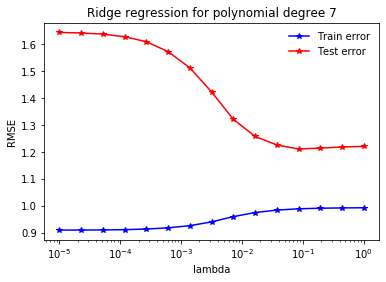

In [97]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)